# Saddle point systems

$$
\def\ddt#1{\frac{\mathrm{d}#1}{\mathrm{d}t}}
\renewcommand{\vec}{\boldsymbol}
\newcommand{\uvec}[1]{\vec{\hat{#1}}}
\newcommand{\utangent}{\uvec{\tau}}
\newcommand{\unormal}{\uvec{n}}
\renewcommand{\d}{\,\mathrm{d}}
$$

Saddle systems comprise an important part of solving mechanics problems with
constraints. In such problems, there is an underlying system to solve, and the
addition of constraints requires that the system is subjected to additional
forces (constraint forces, or Lagrange multipliers) that enforce these constraints
in the system. Examples of such constrained systems are the divergence-free
velocity constraint in incompressible flow (for which pressure is the associated
Lagrange multiplier field), the no-slip and/or no-flow-through condition in
general fluid systems adjacent to impenetrable bodies, and joint constraints in
rigid-body mechanics.

A general saddle-point system has the form

$$\left[ \begin{array}{cc} A & B_1^T \\ B_2 & C\end{array}\right] \left(\begin{array}{c}u\\f \end{array}\right) = \left(\begin{array}{c}r_1\\r_2 \end{array}\right)$$

We are primarily interested in cases when the operator $A$ is symmetric and positive semi-definite,
which is fairly typical. It is also fairly common for $B_1 = B_2$, so that the
whole system is symmetric.

[ConstrainedSystems.jl](https://github.com/JuliaIBPM/ConstrainedSystems.jl) allows us to solve such systems for $u$ and $f$ in a fairly easy way.
We need only to provide rules for how to evaluate the actions of the various
operators in the system. Let us use an example to show how this can be done.

In [1]:
using ConstrainedSystems
using CartesianGrids
using Plots

## Translating cylinder in potential flow

In irrotational, incompressible flow, the streamfunction $\psi$ satisfies Laplace's equation,

$$\nabla^2 \psi = 0$$

On the surface of an impenetrable body, the streamfunction must obey the constraint

$$\psi = \psi_b$$

where $\psi_b$ is the streamfunction associated with the body's motion. Let us
suppose the body is moving vertically with velocity 1. Then $\psi_b = -x$ for all
points inside or on the surface of the body. Thus, the streamfunction field outside
this body is governed by Laplace's equation subject to the constraint.

Let us solve this problem on a staggered grid, using the tools discussed in
[CartesianGrids](https://juliaibpm.github.io/CartesianGrids.jl/latest/), including the regularization and interpolation methods to
immerse the body shape on the grid. Then our saddle-point system has the form

$$\left[ \begin{array}{cc} L & R \\ E & 0\end{array}\right] \left(\begin{array}{c}\psi\\f \end{array}\right) = \left(\begin{array}{c}0\\\psi_b \end{array}\right)$$

where $L$ is the discrete Laplacian, $R$ is the regularization operator, and
$E$ is the interpolation operator.

Physically, $f$ isn't really a force here, but
rather, represents the strengths of distributed singularities on the surface.
In fact, this strength represents the jump in normal derivative of $\psi$ across
the surface. Since this normal derivative is equivalent to the tangential velocity,
$f$ is the strength of the bound vortex sheet on the surface. This will be useful
to know when we check the value of $f$ obtained in our solution.

First, let us set up the body, centered at $(1,1)$ and of radius $1/2$. We will
also initialize a data structure for the force:

In [2]:
n = 128; θ = range(0,stop=2π,length=n+1);
xb = 1.0 .+ 0.5*cos.(θ[1:n]); yb = 1.0 .+ 0.5*sin.(θ[1:n]);
X = VectorData(xb,yb);
ψb = ScalarData(X);
f = similar(ψb);

Now let's set up a grid of size $102\times 102$ (including the usual layer
of ghost cells) and physical dimensions $2\times 2$.

In [3]:
nx = 102; ny = 102; Lx = 2.0; dx = Lx/(nx-2);
w = Nodes(Dual,(nx,ny));
ψ = similar(w);

We need to set up the operators now. First, the Laplacian:

In [4]:
L = plan_laplacian(size(w),with_inverse=true)

Discrete Laplacian (and inverse) on a (nx = 102, ny = 102) grid acting on Float64 data with
               factor 1.0 and spacing 1.0

Note that we have made sure that this operator has an inverse. It is important
that this operator, which represents the `A` matrix in our saddle system, comes
with an associated backslash `\\` operation to carry out the inverse.

Now we need to set up the regularization `R` and interpolation `E` operators.

In [5]:
regop = Regularize(X,dx;issymmetric=true)
Rmat, Emat = RegularizationMatrix(regop,ψb,w);

Now we are ready to set up the system. The solution and right-hand side vectors
are set up using `SaddleVector`.

In [6]:
rhs = SaddleVector(w,ψb)
sol = SaddleVector(ψ,f)

(Dual nodes in a (nx = 102, ny = 102) cell grid of type Float64 data
  Number of Dual nodes: (nx = 102, ny = 102), [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

and the saddle system is then set up with the three operators; the $C$ operator
is presumed to be zero when it is not provided.

In [7]:
A = SaddleSystem(L,Emat,Rmat,rhs)

Saddle system with 10404 states and 128 constraints and
   State vector of type Nodes{Dual, 102, 102, Float64, Matrix{Float64}}
   Constraint vector of type ScalarData{128, Float64, Vector{Float64}}
   Elements of type Float64
using a Direct solver


Note that all of the operators we have provided are either matrices (like `Emat` and `Rmat`)
or functions or function-like operators (like `L`). The `SaddleSystem` constructor
allows either. However, the order is important: we must supply $A$, $B_2$, $B_1^T$, and possibly $C$, in that order.

Let's solve the system. We need to set the right-hand side. We will set `ψb`,
but this will also change `rhs`, since that vector is pointing to the same object.

In [8]:
ψb .= -(xb.-1);

The right-hand side of the Laplace equation is zero. The right-hand side of the
constraint is the specified streamfunction on the body. Note that we have
subtracted the circle center from the $x$ positions on the body. The reason for
this will be discussed in a moment.

We solve the system with the convenient shorthand of the backslash:

In [9]:
sol .= A\rhs # hide
@time sol .= A\rhs

  0.000976 seconds (197 allocations: 419.125 KiB)


(Dual nodes in a (nx = 102, ny = 102) cell grid of type Float64 data
  Number of Dual nodes: (nx = 102, ny = 102), [-0.04977243011213832, -0.050629950442593656, -0.050002261277636045, -0.050317009359109065, -0.04827965305847645, -0.04858716451912853, -0.049820023191423646, -0.04520058738451454, -0.04882906345775734, -0.04350404395265989  …  -0.046350751558954774, -0.04350404395267949, -0.048829063457742995, -0.045200587384527896, -0.04982002319141003, -0.04858716451913668, -0.04827965305847658, -0.050317009359104166, -0.0500022612776417, -0.05062995044259202])

Just to point out how fast it can be, we have also timed it. It's pretty fast.

We can obtain the state vector and the constraint vector from `sol` using some
convenience functions `state(sol)` and `constraint(sol)`.

Now, let's plot the solution in physical space. We'll plot the body shape for
reference, also.

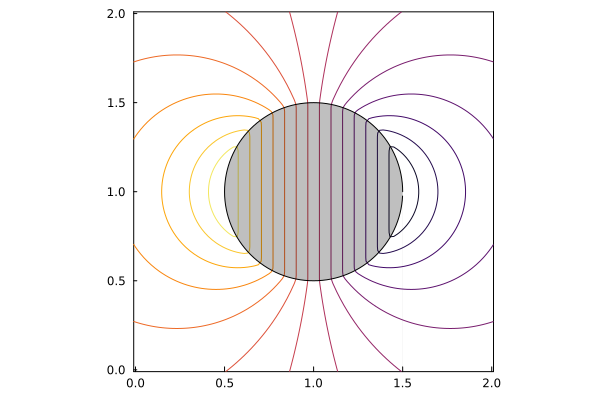

In [10]:
xg, yg = coordinates(w,dx=dx)
plot(xg,yg,state(sol),xlim=(-Inf,Inf),ylim=(-Inf,Inf))
plot!(xb,yb,fillcolor=:black,fillrange=0,fillalpha=0.25,linecolor=:black)

The solution shows the streamlines for a circle in vertical motion, as expected.
All of the streamlines inside the circle are vertical.

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*